In [1]:
import os
os.chdir("C:/Users/MaxT/Desktop/Internet Explorer/max/BOOST!/BCW")

# Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, recall_score, confusion_matrix, plot_confusion_matrix
from missingpy import MissForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter

C:\Users\MaxT\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import Data

In [3]:
df = pd.read_csv('telco.csv')   #Sesuaikan dengan directory (os.chdir)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape 

(7043, 21)

In [6]:
df.info()  #Melihat categorical dan numerical features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Data Preprocessing

#### Customer ID berbeda untuk setiap observasi dan tidak menunjukkan korelasi dengan target variable secara independen. 

In [7]:
df = df.drop(columns=['customerID'])

#### Untuk target variable, ubah Churn 'No' dan 'Yes' menjadi binary '0' dan '1' dengan LabelEncoder. Setelah itu perhatikan proporsi '0' dan '1' pada feature Churn

In [8]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

In [9]:
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

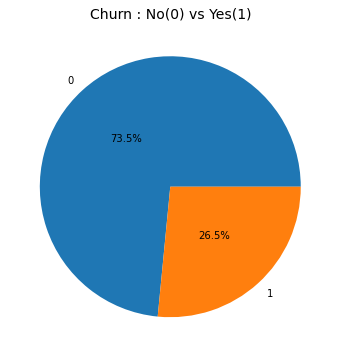

In [10]:
pie, ax = plt.subplots(figsize=[10,6])
labels = df['Churn'].value_counts().index
plt.pie(x= df['Churn'].value_counts(), autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Churn : No(0) vs Yes(1)", fontsize=14)
plt.show()

#### Dari grafik target variable, jumlah 'No'(0) mencapai 73.5% (5174 observasi) dan 'Yes'(1) mencapai 26.5% (1869 observasi). Sehingga data imbalanced dengan 'No' sebagai majority dan 'Yes' sebagai minority. Hal ini berpengaruh pada metric yang akan digunakan untuk evaluasi serta parameter pada model

#### Setelah itu, Feature 'TotalCharges' seharusnya numerical, convert dengan pd.to_numeric, setelah itu perhatikan missing valuenya

In [11]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.isnull().sum().sort_values(ascending=False).head()

TotalCharges     11
Churn             0
SeniorCitizen     0
Partner           0
Dependents        0
dtype: int64

#### Lakukan imputasi pada missing value dengan random forest (Serupa dengan cara kerja MICE yang melakukan iterasi berulang dengan random forest)

In [12]:
MFimputer = MissForest()
Xmf = df.select_dtypes(exclude='object').drop(columns=['Churn'])
X_imputed = MFimputer.fit_transform(Xmf)
X_imputed = pd.DataFrame(X_imputed, columns=df.select_dtypes(exclude='object').drop(columns=['Churn']).columns)  #convert array to dataframe
df['TotalCharges'] = X_imputed['TotalCharges']

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


#### Pastikan sudah tidak ada missing value

In [13]:
df.isnull().sum().sort_values(ascending=False).head()

Churn            0
TotalCharges     0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

#### Pada dataset, terdapat 7043 data dan 20 feature, dengan 4 numerical feature dan 16 categorical feature. Cek apakah terdapat outlier melalui boxplot (hanya di plot 3 feature, karena salah satu feature merupakan binary dan seharusnya dimasukkan sebagai categorical, namun disini dianggap sebagai hasil one-hot encoding dg k-1 kolom)

C:\Users\MaxT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='TotalCharges'>

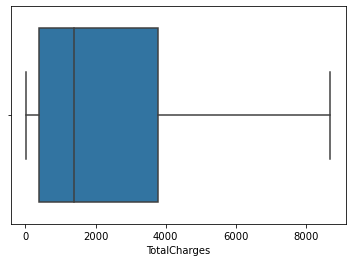

In [15]:
sns.boxplot(df['TotalCharges'])

C:\Users\MaxT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tenure'>

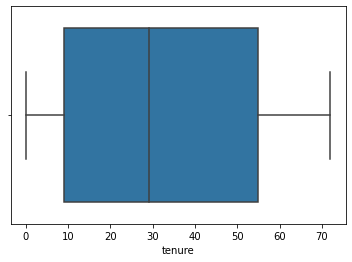

In [16]:
sns.boxplot(df['tenure'])

C:\Users\MaxT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MonthlyCharges'>

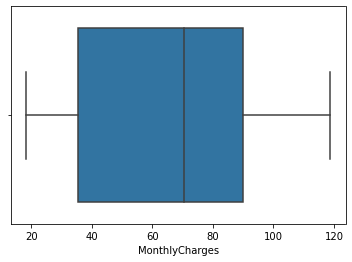

In [17]:
sns.boxplot(df['MonthlyCharges'])

#### Tidak terlihat ada outlier pada boxplot.

#### Dikarenakan beberapa tree-based model seperti xgboost tidak menerima categorical value sebagai input, maka kita akan melakukan encoding pada categorical variable menjadi numerical. Pertama akan dilihat terlebih dahulu value dari masing-masing categorical feature

In [18]:
for i in df.select_dtypes(include='object').columns:
    print(df[i].value_counts(ascending=False))
    print('Jumlah Distinct Value :', df[i].nunique())
    print(30*'-')

Male      3555
Female    3488
Name: gender, dtype: int64
Jumlah Distinct Value : 2
------------------------------
No     3641
Yes    3402
Name: Partner, dtype: int64
Jumlah Distinct Value : 2
------------------------------
No     4933
Yes    2110
Name: Dependents, dtype: int64
Jumlah Distinct Value : 2
------------------------------
Yes    6361
No      682
Name: PhoneService, dtype: int64
Jumlah Distinct Value : 2
------------------------------
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Jumlah Distinct Value : 3
------------------------------
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
Jumlah Distinct Value : 3
------------------------------
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
Jumlah Distinct Value : 3
------------------------------
No                     3088
Yes                    2429


#### Cek korelasi antar variable dengan heatmap

<AxesSubplot:>

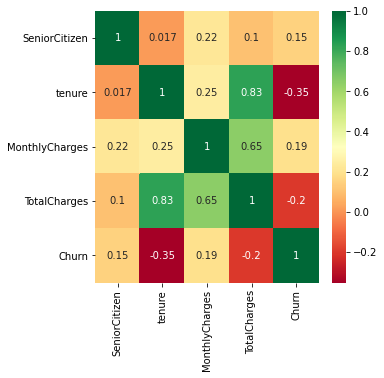

In [19]:
hmat = df.corr()
top_corr_features = hmat.index
plt.figure(figsize=(5,5))
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### Untuk feature yang saling berkorelasi, akan dipertimbangkan untuk di drop (plug and error). Pada dataset, tidak ada feature yang valuenya mempunyai intrinsic order, maka akan dilakukan one-hot encoding pada categorical variable.

In [20]:
df1 = df.copy()
df1_noncat = df1.select_dtypes(exclude='object')
catnama = [x for x in df1.select_dtypes(include='object').columns]
X_train1 = pd.get_dummies(df1[catnama], drop_first=True)
df1 = pd.concat([df1_noncat, X_train1], axis=1)

In [21]:
df1.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


##### *Note : Telah dicoba dilakukan PCA untuk reduce dimension pada dataset setelah One-hot encoding, namun hasil PCA tidak memberikan hasil lebih baik dibandingkan tanpa PCA (dengan metric ROC-AUC)

# Train Test Split

In [22]:
X_trainori, X_testori, y_trainori, y_testori = train_test_split(df1.drop(columns=['Churn']), df1['Churn'], test_size=0.3, stratify= df1['Churn'], random_state=7)

##### Pada imbalanced Churn dataset ini, metric roc-auc & recall akan menitikberatkan terhadap pelanggan yang kemungkinan churn. Oleh sebab itu, meminimalkan false negative (Predicted : Not Churn, Actual : Churn) menjadi hal yang penting. Daripada kehilangan pelanggan akibat treatment yang kurang akibat prediksi yang salah, maka lebih baik meminimalkan false negative. Dalam hal ini, recall serta roc-auc menjadi opsi metric yang baik

# Define Function

In [23]:
def modelfit(alg, X, y, X_train, X_test, y_train, y_test, performCV=True, printFeatureImportance=True, cv_folds=10):
    
    alg.fit(X_train, y_train)
     
    ytest_predictions = alg.predict(X_test)
    ytest_predprob = alg.predict_proba(X_test)[:,1]
    ytrain_predprob = alg.predict_proba(X_train)[:,1]
    
    if performCV:
        kfold = StratifiedKFold(n_splits=5)     #Gunakan StratifiedKFold untuk imbalanced dataset
        cv_score = cross_val_score(alg, X, y, cv=kfold, scoring='roc_auc')
    
    print("\nModel Report")
    print("AUC Score (Train): %f" % roc_auc_score(y_train, ytrain_predprob))
    print("AUC Score (Test): %f" % roc_auc_score(y_test, ytest_predprob))
    
    if performCV:
        print ("CV Score on train set : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

#### Tree-based model yang akan digunakan antara lain : Gradient Boosting Method, Random Forest, dan XGBoost

# 1. Gradient Boosting Method

In [24]:
gbm = GradientBoostingClassifier(random_state=7)  #baseline


Model Report
AUC Score (Train): 0.878141
AUC Score (Test): 0.853080
CV Score on train set : Mean - 0.8455566 | Std - 0.01028287 | Min - 0.8305381 | Max - 0.8582965


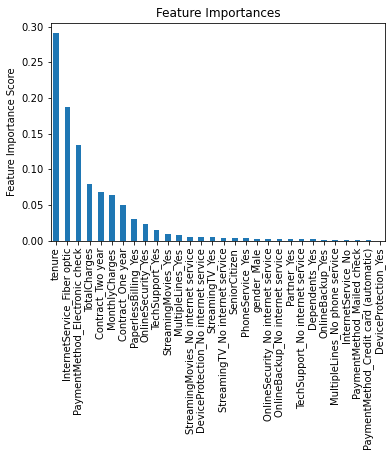

In [25]:
modelfit(gbm, df1.drop(columns=['Churn']) , df1['Churn'], X_trainori, X_testori, y_trainori, y_testori, performCV=True, printFeatureImportance=True)

#### Dengan beberapa kali percobaan, prediksi dengan 24 fitur pertama memberikan hasil terbaik (dengan gbm semula dan random state yang sama). 


Model Report
AUC Score (Train): 0.877673
AUC Score (Test): 0.853401
CV Score on train set : Mean - 0.845994 | Std - 0.01057431 | Min - 0.8317407 | Max - 0.8586182


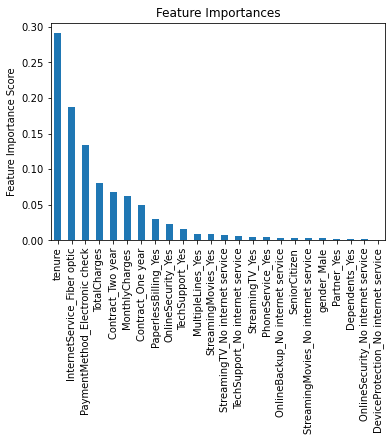

In [26]:
puluh4 = list(pd.Series(gbm.feature_importances_, X_trainori.columns).sort_values(ascending=False)[0:24].index)
X_trainm, X_testm, y_trainm, y_testm = train_test_split(df1[puluh4], df1['Churn'], test_size=0.3, stratify= df1['Churn'], random_state=7)
modelfit(gbm, df1[puluh4] , df1['Churn'], X_trainm, X_testm, y_trainm, y_testm, performCV=True, printFeatureImportance=True)

#### Hyperparameter tuning dengan GridSearch

##### 1. N estimators & learning rate

In [27]:
param_test1m = {'learning_rate':[0.1,0.05,0.01,0.005,0.001], 'n_estimators':[300,400,500,600,700]}
gsearch1m = GridSearchCV(estimator = GradientBoostingClassifier(min_samples_split=20,min_samples_leaf=2,max_depth=4,max_features='sqrt',subsample=0.8,random_state=7), param_grid = param_test1m, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch1m.fit(X_trainm, y_trainm)
gsearch1m.cv_results_['mean_test_score'], gsearch1m.cv_results_['params'], gsearch1m.best_params_, gsearch1m.best_score_

(array([0.82979781, 0.8251561 , 0.82106869, 0.81916237, 0.81668877,
        0.83889168, 0.83579045, 0.83334391, 0.83139839, 0.82928557,
        0.84382306, 0.84430608, 0.84431843, 0.84436293, 0.84396384,
        0.84171247, 0.84252949, 0.84294169, 0.84349692, 0.84364707,
        0.83885919, 0.83918455, 0.83920512, 0.8394374 , 0.83977749]),
 [{'learning_rate': 0.1, 'n_estimators': 300},
  {'learning_rate': 0.1, 'n_estimators': 400},
  {'learning_rate': 0.1, 'n_estimators': 500},
  {'learning_rate': 0.1, 'n_estimators': 600},
  {'learning_rate': 0.1, 'n_estimators': 700},
  {'learning_rate': 0.05, 'n_estimators': 300},
  {'learning_rate': 0.05, 'n_estimators': 400},
  {'learning_rate': 0.05, 'n_estimators': 500},
  {'learning_rate': 0.05, 'n_estimators': 600},
  {'learning_rate': 0.05, 'n_estimators': 700},
  {'learning_rate': 0.01, 'n_estimators': 300},
  {'learning_rate': 0.01, 'n_estimators': 400},
  {'learning_rate': 0.01, 'n_estimators': 500},
  {'learning_rate': 0.01, 'n_estimators

##### learning_rate : 0.01 , n_estimators : 600
##### 2. Max depth & min_samples_split

In [32]:
param_test2m = {'max_depth':[2,3,4], 'min_samples_split':[2,3,4,5]}
gsearch2m = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600 ,max_features='sqrt',subsample=0.8,random_state=7), param_grid = param_test2m, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch2m.fit(X_trainm, y_trainm)
gsearch2m.cv_results_['mean_test_score'], gsearch2m.cv_results_['params'], gsearch2m.best_params_, gsearch2m.best_score_

(array([0.84301877, 0.84302404, 0.84302298, 0.84301455, 0.84450987,
        0.84456578, 0.84448243, 0.84450459, 0.84442023, 0.84445194,
        0.84439571, 0.84456573]),
 [{'max_depth': 2, 'min_samples_split': 2},
  {'max_depth': 2, 'min_samples_split': 3},
  {'max_depth': 2, 'min_samples_split': 4},
  {'max_depth': 2, 'min_samples_split': 5},
  {'max_depth': 3, 'min_samples_split': 2},
  {'max_depth': 3, 'min_samples_split': 3},
  {'max_depth': 3, 'min_samples_split': 4},
  {'max_depth': 3, 'min_samples_split': 5},
  {'max_depth': 4, 'min_samples_split': 2},
  {'max_depth': 4, 'min_samples_split': 3},
  {'max_depth': 4, 'min_samples_split': 4},
  {'max_depth': 4, 'min_samples_split': 5}],
 {'max_depth': 3, 'min_samples_split': 3},
 0.8445657813689806)

##### max_depth : 3   min_samples_split : 3
##### 3. Min_samples_leaf

In [33]:
param_test3m = {'min_samples_leaf':range(1,10,2)}
gsearch3m = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, min_samples_split=3, max_depth=3, n_estimators=600 ,max_features='sqrt',subsample=0.8,random_state=7), param_grid = param_test3m, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch3m.fit(X_trainm, y_trainm)
gsearch3m.cv_results_['mean_test_score'], gsearch3m.cv_results_['params'], gsearch3m.best_params_, gsearch3m.best_score_

(array([0.84456578, 0.84455702, 0.84429379, 0.84423297, 0.84413168]),
 [{'min_samples_leaf': 1},
  {'min_samples_leaf': 3},
  {'min_samples_leaf': 5},
  {'min_samples_leaf': 7},
  {'min_samples_leaf': 9}],
 {'min_samples_leaf': 1},
 0.8445657813689806)

##### min_samples_leaf : 1
##### 4. Max_features

In [34]:
param_test4m = {'max_features':[2,3,4,5,6,7,8,10,12]}
gsearch4m = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, min_samples_split=3, max_depth=3, min_samples_leaf=1, n_estimators=600 ,subsample=0.8,random_state=7), param_grid = param_test4m, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch4m.fit(X_trainm, y_trainm)
gsearch4m.cv_results_['mean_test_score'], gsearch4m.cv_results_['params'], gsearch4m.best_params_, gsearch4m.best_score_

(array([0.8439456 , 0.84453359, 0.84456578, 0.84430019, 0.84401465,
        0.84372011, 0.84350823, 0.84301301, 0.84273673]),
 [{'max_features': 2},
  {'max_features': 3},
  {'max_features': 4},
  {'max_features': 5},
  {'max_features': 6},
  {'max_features': 7},
  {'max_features': 8},
  {'max_features': 10},
  {'max_features': 12}],
 {'max_features': 4},
 0.8445657813689806)

##### max_features : 4
##### 5.Subsample

In [37]:
param_test5m = {'subsample':[0.8,0.85,0.9,0.95,1]}
gsearch5m = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, min_samples_split=3, max_depth=3, min_samples_leaf=1, n_estimators=600 ,max_features=4,random_state=7), param_grid = param_test5m, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch5m.fit(X_trainm, y_trainm)
gsearch5m.cv_results_['mean_test_score'], gsearch5m.cv_results_['params'], gsearch5m.best_params_, gsearch5m.best_score_

(array([0.84456578, 0.84448486, 0.84468773, 0.84448077, 0.84405507]),
 [{'subsample': 0.8},
  {'subsample': 0.85},
  {'subsample': 0.9},
  {'subsample': 0.95},
  {'subsample': 1}],
 {'subsample': 0.9},
 0.8446877318494546)

##### subsample : 0.9

In [38]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, min_samples_split=3, max_depth=3, min_samples_leaf=1, n_estimators=600 ,max_features=4, subsample=0.9 ,random_state=7)


Model Report
AUC Score (Train): 0.861535
AUC Score (Test): 0.856139
CV Score on train set : Mean - 0.8495946 | Std - 0.01051536 | Min - 0.8354065 | Max - 0.8636906


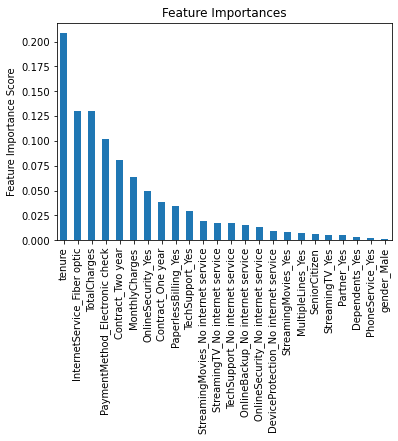

In [40]:
modelfit(gbm_tuned_2, df1[puluh4], df1['Churn'], X_trainm, X_testm, y_trainm, y_testm, performCV=True, printFeatureImportance=True)

# 2. Random Forest

In [46]:
rf = RandomForestClassifier(class_weight = 'balanced', random_state=7)  #'balanced' untuk imbalanced dataset


Model Report
AUC Score (Train): 0.999867
AUC Score (Test): 0.835250
CV Score on train set : Mean - 0.8235982 | Std - 0.01376459 | Min - 0.8032525 | Max - 0.8393255


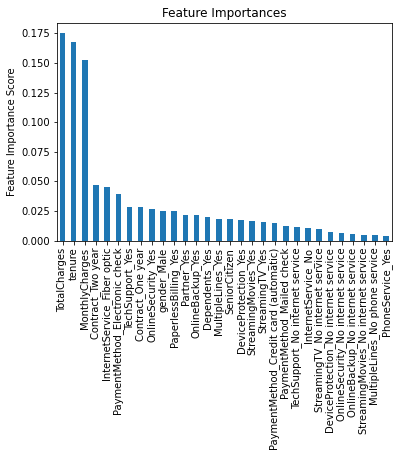

In [47]:
modelfit(rf, df1.drop(columns=['Churn']), df1['Churn'], X_trainori, X_testori, y_trainori, y_testori, performCV=True, printFeatureImportance=True) #baseline

##### 1. n_estimators

In [44]:
param_test1r = {'n_estimators':[100,250,500,750,1000]}
gsearch1r = GridSearchCV(estimator = RandomForestClassifier(class_weight='balanced', random_state=7), param_grid = param_test1r, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch1r.fit(X_trainori, y_trainori)
gsearch1r.cv_results_['mean_test_score'], gsearch1r.cv_results_['params'], gsearch1r.best_params_, gsearch1r.best_score_

(array([0.81717234, 0.82069359, 0.82178892, 0.82175862, 0.82174099]),
 [{'n_estimators': 100},
  {'n_estimators': 250},
  {'n_estimators': 500},
  {'n_estimators': 750},
  {'n_estimators': 1000}],
 {'n_estimators': 500},
 0.8217889180048523)

##### n_estimators : 500
##### 2. Max_depth & min_samples_split

In [54]:
param_test2r = {'max_depth':[5,6,7], 'min_samples_split':[6,7,8]}
gsearch2r = GridSearchCV(estimator = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=7), param_grid = param_test2r, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch2r.fit(X_trainori, y_trainori)
gsearch2r.cv_results_['mean_test_score'], gsearch2r.cv_results_['params'], gsearch2r.best_params_, gsearch2r.best_score_

(array([0.83939871, 0.83947524, 0.83948262, 0.84086425, 0.84105846,
        0.84091813, 0.84099767, 0.84093221, 0.84068416]),
 [{'max_depth': 5, 'min_samples_split': 6},
  {'max_depth': 5, 'min_samples_split': 7},
  {'max_depth': 5, 'min_samples_split': 8},
  {'max_depth': 6, 'min_samples_split': 6},
  {'max_depth': 6, 'min_samples_split': 7},
  {'max_depth': 6, 'min_samples_split': 8},
  {'max_depth': 7, 'min_samples_split': 6},
  {'max_depth': 7, 'min_samples_split': 7},
  {'max_depth': 7, 'min_samples_split': 8}],
 {'max_depth': 6, 'min_samples_split': 7},
 0.8410584599779396)

##### max_depth : 6 , min_samples_split : 7
##### 3. min_samples_leaf

In [56]:
param_test3r = {'min_samples_leaf':range(1,10,2)}
gsearch3r = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=7, max_depth=6, n_estimators=500 , class_weight='balanced', random_state=7), param_grid = param_test3r, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch3r.fit(X_trainori, y_trainori)
gsearch3r.cv_results_['mean_test_score'], gsearch3r.cv_results_['params'], gsearch3r.best_params_, gsearch3r.best_score_

(array([0.84105846, 0.84099462, 0.84092763, 0.84057559, 0.84071195]),
 [{'min_samples_leaf': 1},
  {'min_samples_leaf': 3},
  {'min_samples_leaf': 5},
  {'min_samples_leaf': 7},
  {'min_samples_leaf': 9}],
 {'min_samples_leaf': 1},
 0.8410584599779396)

##### min_samples_leaf : 1
##### 4. Max features 

In [58]:
param_test4r = {'max_features':[4,5,6,7,8]}
gsearch4r = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=7, max_depth=6, min_samples_leaf=1, n_estimators=500 , class_weight='balanced', random_state=7), param_grid = param_test4r, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch4r.fit(X_trainori, y_trainori)
gsearch4r.cv_results_['mean_test_score'], gsearch4r.cv_results_['params'], gsearch4r.best_params_, gsearch4r.best_score_

(array([0.84013691, 0.84105846, 0.84085455, 0.84107705, 0.8405559 ]),
 [{'max_features': 4},
  {'max_features': 5},
  {'max_features': 6},
  {'max_features': 7},
  {'max_features': 8}],
 {'max_features': 7},
 0.8410770492479411)

##### max_features : 7
##### 5. Bootstrap

In [59]:
param_test5r = {'bootstrap': [True, False]}
gsearch5r = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=7, max_depth=6, min_samples_leaf=1, max_features=7, n_estimators=500, class_weight='balanced', random_state=7), param_grid = param_test5r, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch5r.fit(X_trainori, y_trainori)
gsearch5r.cv_results_['mean_test_score'], gsearch5r.cv_results_['params'], gsearch5r.best_params_, gsearch5r.best_score_

(array([0.84107705, 0.84019284]),
 [{'bootstrap': True}, {'bootstrap': False}],
 {'bootstrap': True},
 0.8410770492479411)

##### bootstrap : True

In [60]:
rf_tuned = RandomForestClassifier(min_samples_split=7, max_depth=6, min_samples_leaf=1, max_features=7, n_estimators=500, bootstrap=True, class_weight='balanced', random_state=7)


Model Report
AUC Score (Train): 0.869437
AUC Score (Test): 0.855098
CV Score on train set : Mean - 0.8459106 | Std - 0.01168824 | Min - 0.8308882 | Max - 0.859862


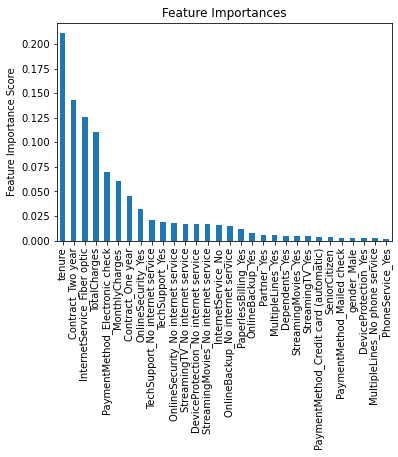

In [61]:
modelfit(rf_tuned, df1.drop(columns=['Churn']), df1['Churn'], X_trainori, X_testori, y_trainori, y_testori, performCV=True, printFeatureImportance=True)

# 3. XGBoost

In [62]:
# estimate scale_pos_weight value for imbalanced dataset
counter = Counter(df1['Churn'])
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 2.768


In [63]:
xgb = XGBClassifier(booster='gbtree', scale_pos_weight=2.768, random_state=7, use_label_encoder =False, verbosity=0)


Model Report
AUC Score (Train): 0.991706
AUC Score (Test): 0.832114
CV Score on train set : Mean - 0.8215253 | Std - 0.01274358 | Min - 0.8080679 | Max - 0.8427601


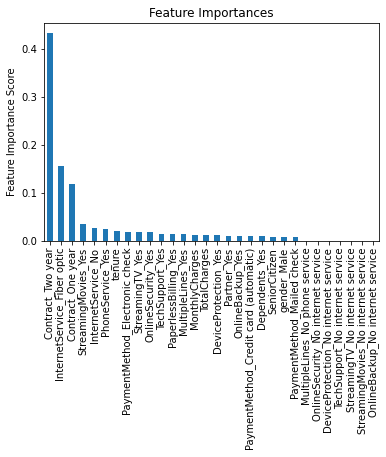

In [65]:
modelfit(xgb, df1.drop(columns=['Churn']), df1['Churn'], X_trainori, X_testori, y_trainori, y_testori, performCV=True, printFeatureImportance=True) #baseline

##### 1. learning_rate & n_estimators

In [64]:
param_test1x = {'learning_rate':[0.1,0.05,0.01,0.005], 'n_estimators':[100,250,500]}
gsearch1x = GridSearchCV(estimator = XGBClassifier(booster='gbtree', scale_pos_weight=2.768, random_state=7, use_label_encoder =False, verbosity=0), param_grid = param_test1x, scoring='roc_auc', cv=5)
gsearch1x.fit(X_trainori, y_trainori)
gsearch1x.cv_results_['mean_test_score'], gsearch1x.cv_results_['params'], gsearch1x.best_params_, gsearch1x.best_score_

(array([0.82892007, 0.81897828, 0.81128861, 0.83168395, 0.82682519,
        0.81987109, 0.83163882, 0.83403723, 0.83195101, 0.82828615,
        0.83195461, 0.83391862]),
 [{'learning_rate': 0.1, 'n_estimators': 100},
  {'learning_rate': 0.1, 'n_estimators': 250},
  {'learning_rate': 0.1, 'n_estimators': 500},
  {'learning_rate': 0.05, 'n_estimators': 100},
  {'learning_rate': 0.05, 'n_estimators': 250},
  {'learning_rate': 0.05, 'n_estimators': 500},
  {'learning_rate': 0.01, 'n_estimators': 100},
  {'learning_rate': 0.01, 'n_estimators': 250},
  {'learning_rate': 0.01, 'n_estimators': 500},
  {'learning_rate': 0.005, 'n_estimators': 100},
  {'learning_rate': 0.005, 'n_estimators': 250},
  {'learning_rate': 0.005, 'n_estimators': 500}],
 {'learning_rate': 0.01, 'n_estimators': 250},
 0.834037225088546)

##### learning rate : 0.01 , n_estimators : 250
##### 2. max_depth & min_child_weight

In [66]:
param_test2x = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}
gsearch2x = GridSearchCV(estimator = XGBClassifier(booster='gbtree', scale_pos_weight=2.768, learning_rate=0.01, n_estimators=250, random_state=7, use_label_encoder =False, verbosity=0), param_grid = param_test2x, scoring='roc_auc', cv=5)
gsearch2x.fit(X_trainori, y_trainori)
gsearch2x.cv_results_['mean_test_score'], gsearch2x.cv_results_['params'], gsearch2x.best_params_, gsearch2x.best_score_

(array([0.8384888 , 0.83842277, 0.83848396, 0.83562205, 0.83607198,
        0.83704537, 0.82898209, 0.82930201, 0.83090154, 0.82206579,
        0.82422164, 0.82802219]),
 [{'max_depth': 3, 'min_child_weight': 1},
  {'max_depth': 3, 'min_child_weight': 3},
  {'max_depth': 3, 'min_child_weight': 5},
  {'max_depth': 5, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 3},
  {'max_depth': 5, 'min_child_weight': 5},
  {'max_depth': 7, 'min_child_weight': 1},
  {'max_depth': 7, 'min_child_weight': 3},
  {'max_depth': 7, 'min_child_weight': 5},
  {'max_depth': 9, 'min_child_weight': 1},
  {'max_depth': 9, 'min_child_weight': 3},
  {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1},
 0.8384887982635443)

##### max_depth : 3, min_child_weight : 1
##### 3. Gamma

In [67]:
param_test3x = {'gamma':[0.1,0.2,0.3,0.4,0.5]}
gsearch3x = GridSearchCV(estimator = XGBClassifier(booster='gbtree', max_depth=3, min_child_weight=1,scale_pos_weight=2.768, learning_rate=0.01, n_estimators=250, random_state=7, use_label_encoder =False, verbosity=0), param_grid = param_test3x, scoring='roc_auc', cv=5)
gsearch3x.fit(X_trainori, y_trainori)
gsearch3x.cv_results_['mean_test_score'], gsearch3x.cv_results_['params'], gsearch3x.best_params_, gsearch3x.best_score_

(array([0.8384888 , 0.8384888 , 0.83840867, 0.83840761, 0.83840761]),
 [{'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.3},
  {'gamma': 0.4},
  {'gamma': 0.5}],
 {'gamma': 0.1},
 0.8384887982635443)

##### Gamma : 0.1
##### 4. Subsample & colsample_bytree

In [68]:
param_test4x = {'colsample_bytree':[0.75,0.8,0.85],'subsample':[0.1,0.8]}
gsearch4x = GridSearchCV(estimator = XGBClassifier(booster='gbtree',gamma=0.1,max_depth=3, min_child_weight=1,scale_pos_weight=2.768, learning_rate=0.01, n_estimators=250, random_state=7, use_label_encoder =False, verbosity=0), param_grid = param_test4x, scoring='roc_auc', cv=5)
gsearch4x.fit(X_trainori, y_trainori)
gsearch4x.cv_results_['mean_test_score'], gsearch4x.cv_results_['params'], gsearch4x.best_params_, gsearch4x.best_score_

(array([0.84258075, 0.83992498, 0.84270685, 0.83976982, 0.84265954,
        0.83972422]),
 [{'colsample_bytree': 0.75, 'subsample': 0.1},
  {'colsample_bytree': 0.75, 'subsample': 0.8},
  {'colsample_bytree': 0.8, 'subsample': 0.1},
  {'colsample_bytree': 0.8, 'subsample': 0.8},
  {'colsample_bytree': 0.85, 'subsample': 0.1},
  {'colsample_bytree': 0.85, 'subsample': 0.8}],
 {'colsample_bytree': 0.8, 'subsample': 0.1},
 0.842706849289964)

##### colsample_bytree : 0.8 , subsample : 0.1
##### 5. Reg-alpha

In [69]:
param_test5x = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]}
gsearch5x = GridSearchCV(estimator = XGBClassifier(booster='gbtree',subsample=0.1,colsample_bytree=0.8,gamma=0.1,max_depth=3, min_child_weight=1,scale_pos_weight=2.768, learning_rate=0.01, n_estimators=250, random_state=7, use_label_encoder =False, verbosity=0), param_grid = param_test5x, scoring='roc_auc', cv=5)
gsearch5x.fit(X_trainori, y_trainori)
gsearch5x.cv_results_['mean_test_score'], gsearch5x.cv_results_['params'], gsearch5x.best_params_, gsearch5x.best_score_

(array([0.84270685, 0.84270579, 0.84273009, 0.84264139, 0.84257663]),
 [{'reg_alpha': 0},
  {'reg_alpha': 0.001},
  {'reg_alpha': 0.005},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.05}],
 {'reg_alpha': 0.005},
 0.842730089132214)

##### Reg-alpha : 0.005

In [70]:
xgb_tuned = XGBClassifier(booster='gbtree',subsample=0.1,colsample_bytree=0.8,gamma=0.1,max_depth=3, min_child_weight=1,scale_pos_weight=2.768, learning_rate=0.01, n_estimators=250, reg_alpha=0.005, random_state=7, use_label_encoder =False, verbosity=0)


Model Report
AUC Score (Train): 0.852589
AUC Score (Test): 0.854785
CV Score on train set : Mean - 0.8477269 | Std - 0.01015787 | Min - 0.8338655 | Max - 0.86007


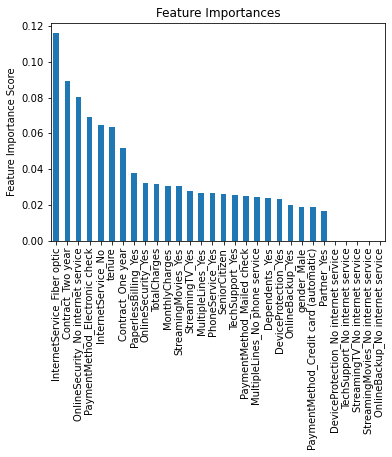

In [72]:
modelfit(xgb_tuned, df1.drop(columns=['Churn']), df1['Churn'], X_trainori, X_testori, y_trainori, y_testori, performCV=True, cv_folds=10)

##### Note : Telah dilakukan percobaan dengan mendrop feature 'MonthCharges' yang terindikasi berkolinearitas tinggi dalam ketiga model ini, namun scorenya yang diberikan lebih rendah dibandingkan tidak di drop, sehingga diputuskan untuk tetap menggunakan feature semula*

##### **kecuali GBM*

# Evaluation

### GBM

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1552
           1       0.70      0.52      0.59       561

    accuracy                           0.81      2113
   macro avg       0.77      0.72      0.73      2113
weighted avg       0.80      0.81      0.80      2113

recall score: 51.515%
roc-auc score: 85.614%


<AxesSubplot:>

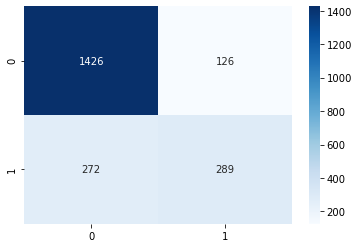

In [93]:
gbm_tuned_2.fit(X_trainm, y_trainm)
yhatr = gbm_tuned_2.predict(X_testm)
yhatrp = gbm_tuned_2.predict_proba(X_testm)[:,1]
print (classification_report(y_testm, yhatr))  
print('recall score: %s' % '{0:.3%}'.format(recall_score(y_testm, yhatr)))
print('roc-auc score: %s' % '{0:.3%}'.format(roc_auc_score(y_testm, yhatrp)))

confusion1 = confusion_matrix(y_testm, yhatr)
sns.heatmap(confusion1, annot=True, fmt='d', cmap='Blues')

## Random Forest

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1552
           1       0.54      0.80      0.64       561

    accuracy                           0.77      2113
   macro avg       0.73      0.78      0.73      2113
weighted avg       0.81      0.77      0.78      2113

recall score: 79.857%
roc-auc score: 85.510%


<AxesSubplot:>

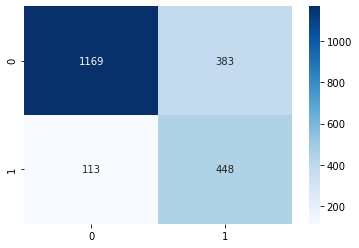

In [94]:
rf_tuned.fit(X_trainori,y_trainori)
yhatr2t = rf_tuned.predict(X_testori)
yhatrp2t = rf_tuned.predict_proba(X_testori)[:,1]
print (classification_report(y_testori, yhatr2t))
print('recall score: %s' % '{0:.3%}'.format(recall_score(y_testori, yhatr2t)))
print('roc-auc score: %s' % '{0:.3%}'.format(roc_auc_score(y_testori, yhatrp2t)))

confusion2 = confusion_matrix(y_testori, yhatr2t)
sns.heatmap(confusion2, annot=True, fmt='d', cmap='Blues')

## XGBoost

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1552
           1       0.54      0.78      0.64       561

    accuracy                           0.77      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.77      0.78      2113

recall score: 77.897%
roc-auc score: 85.479%


<AxesSubplot:>

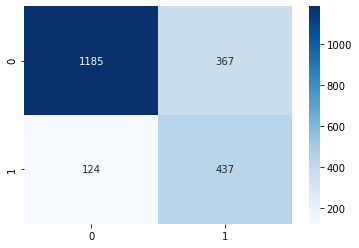

In [95]:
xgb_tuned.fit(X_trainori,y_trainori)
yhatr3t = xgb_tuned.predict(X_testori)
yhatrp3t = xgb_tuned.predict_proba(X_testori)[:,1]
print (classification_report(y_testori, yhatr3t))
print('recall score: %s' % '{0:.3%}'.format(recall_score(y_testori, yhatr3t)))
print('roc-auc score: %s' % '{0:.3%}'.format(roc_auc_score(y_testori, yhatrp3t)))

confusion3 = confusion_matrix(y_testori, yhatr3t)
sns.heatmap(confusion3, annot=True, fmt='d', cmap='Blues')

#### Pada kasus Churn dataset ini, 'False Negative' yang rendah (predicted : no-churn, aslinya : churn) dapat meminimalkan kerugian yang terjadi pada perusahaan. Dibandingkan membiarkan pelanggan pergi akibat prediksi yang salah, perusahaan sebenarnya dapat mencari solusi yang cocok bagi mereka (misalnya memberi diskon ataupun tawaran menarik yang disesuaikan dengan profile pelanggan).

#### Maka dari itu, disini kita memperhatikan metric recall serta roc-auc untuk kasus imbalanced dataset ini. Dari ketiga model diatas yang telah dilakukan tuning, RandomForest memberikan recall serta roc-auc score tertinggi (yang artinya meminimalkan false negative), yaitu 79.857% dan 85.51%